In [916]:
import emcee
import numpy as np
import corner
from multiprocessing import Pool
from bces import bces
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [797]:
# Choose the "true" parameters.
m_true = 1.79
b_true = -0.186
#f_true = 0.534
f_true = 0.075
np.random.seed(10)
# Generate some synthetic data from the model.
N = 71
xtrue = np.sort(0.008 + 0.16*np.random.randn(N))
xerr = 0.016 + 0.009*np.random.rand(N)
x = xtrue + xerr * np.random.randn(N)
y = m_true*x+b_true
yerr = 0.041 + 0.014*np.random.rand(N)
#y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)
y += f_true * np.random.randn(N) # Adding intrinsic scatter

<IPython.core.display.Javascript object>


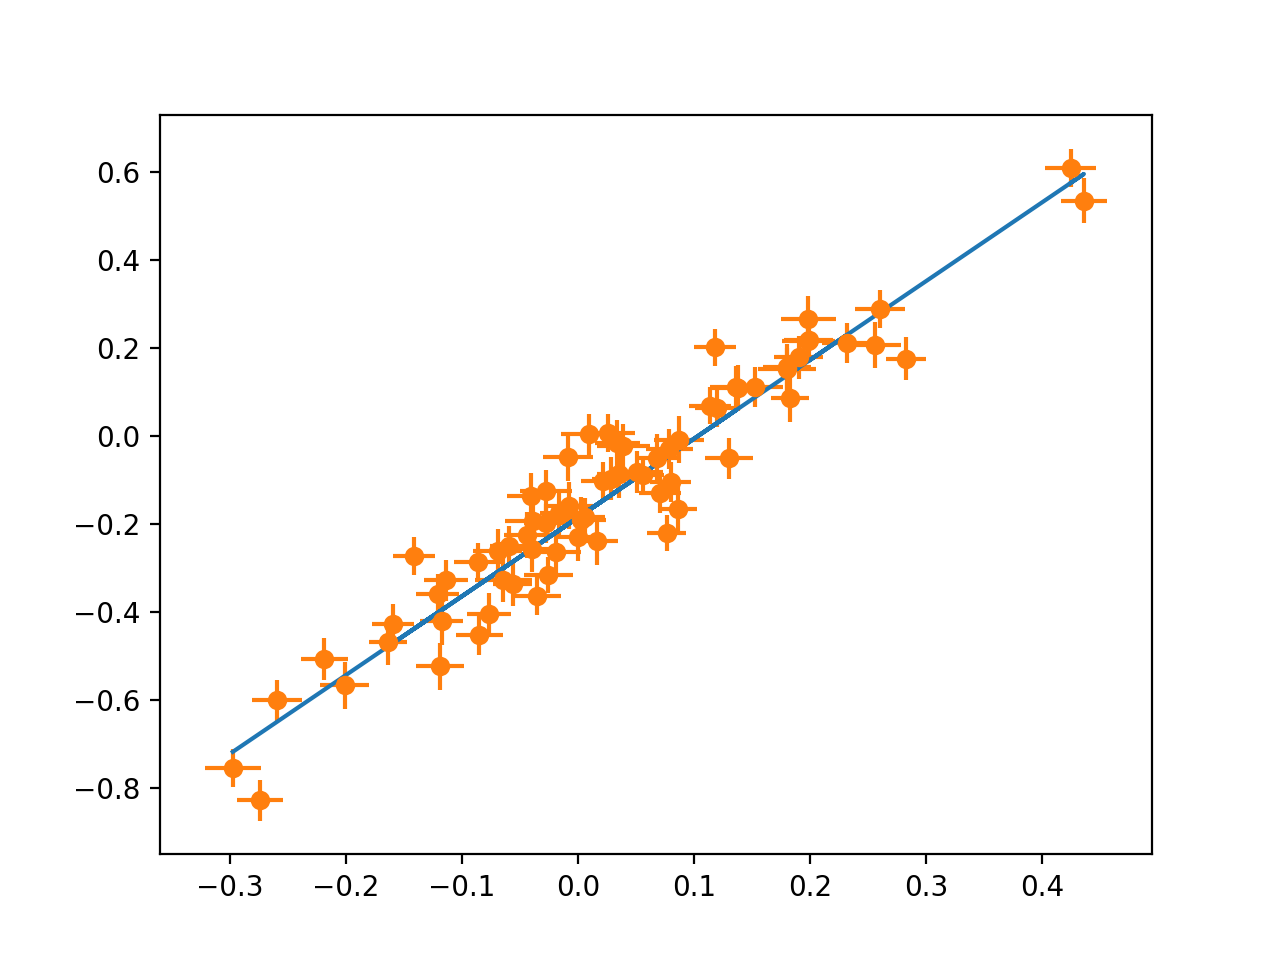

<Container object of 3 artists>

In [809]:
figure()
plot(x,m_true*x+b_true)
errorbar(x,y,yerr=yerr,xerr=xerr,fmt="o")

In [904]:
# def lnlike(param, x, y, xerr,yerr):
#     m, b, log10int_scat = param
#     model = m * x + b
#     #inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
#     inv_sigma2 = 1.0/((yerr**2 + m**2*xerr**2.)/(1. + m**2.) + 10.**(2.*log10int_scat)*np.cos(np.arctan(m))**2.)
#     dmm=(y-model)/np.sqrt(1. + m**2.)
#     return -0.5*(np.sum(dmm**2.*inv_sigma2 - np.log(inv_sigma2)))

def lnlike(param, x, y, xerr,yerr):
    m, b, log10int_scat = param
    model = m * x + b
    #inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    inv_sigma2 = 1.0/((yerr**2 + (m*xerr)**2.) + 10.**(2.*log10int_scat))
    dmm=(y-model)
    return -0.5*(np.sum(dmm**2.*inv_sigma2 - np.log(inv_sigma2)))

def lnprior(param):
    m, b, log10int_scat = param
    if 0. < m < 4. and -2.0 < b < 2.0 and -2. < log10int_scat < 0.:
        return 0.0
    return -np.inf

def lnprob(param, x, y, xerr, yerr):
    lp = lnprior(param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(param, x, y, xerr, yerr)

In [905]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [0., 0., -2.], args=(x, y, xerr, yerr))
m_ml, b_ml, lnf_ml = result["x"]
print m_ml, b_ml, np.exp(lnf_ml)

1.76706782528 -0.176993724536 0.279011342523


In [906]:
np.random.randn(ndim)

array([-0.68540143, -0.79863922,  0.63032718])

In [923]:
ndim, nwalkers = 3, 300
pos = [[0.5,0.2,0.1]*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y,xerr, yerr))
temp=sampler.run_mcmc(pos, 4000)

In [924]:
samples = sampler.chain[:, 2000:, :].reshape((-1, ndim))
samples[:, 2] = 10.**(samples[:, 2])

In [925]:
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [15.87, 50., 84.13],
                                                axis=0)))
print m_mcmc
print b_mcmc
print f_mcmc

(1.7698089784942992, 0.064583190399234658, 0.065402512993716133)
(-0.17708298052051388, 0.009839562155679521, 0.009679613052973296)
(0.052817159232673661, 0.010541410858842873, 0.010295095196008158)


<IPython.core.display.Javascript object>


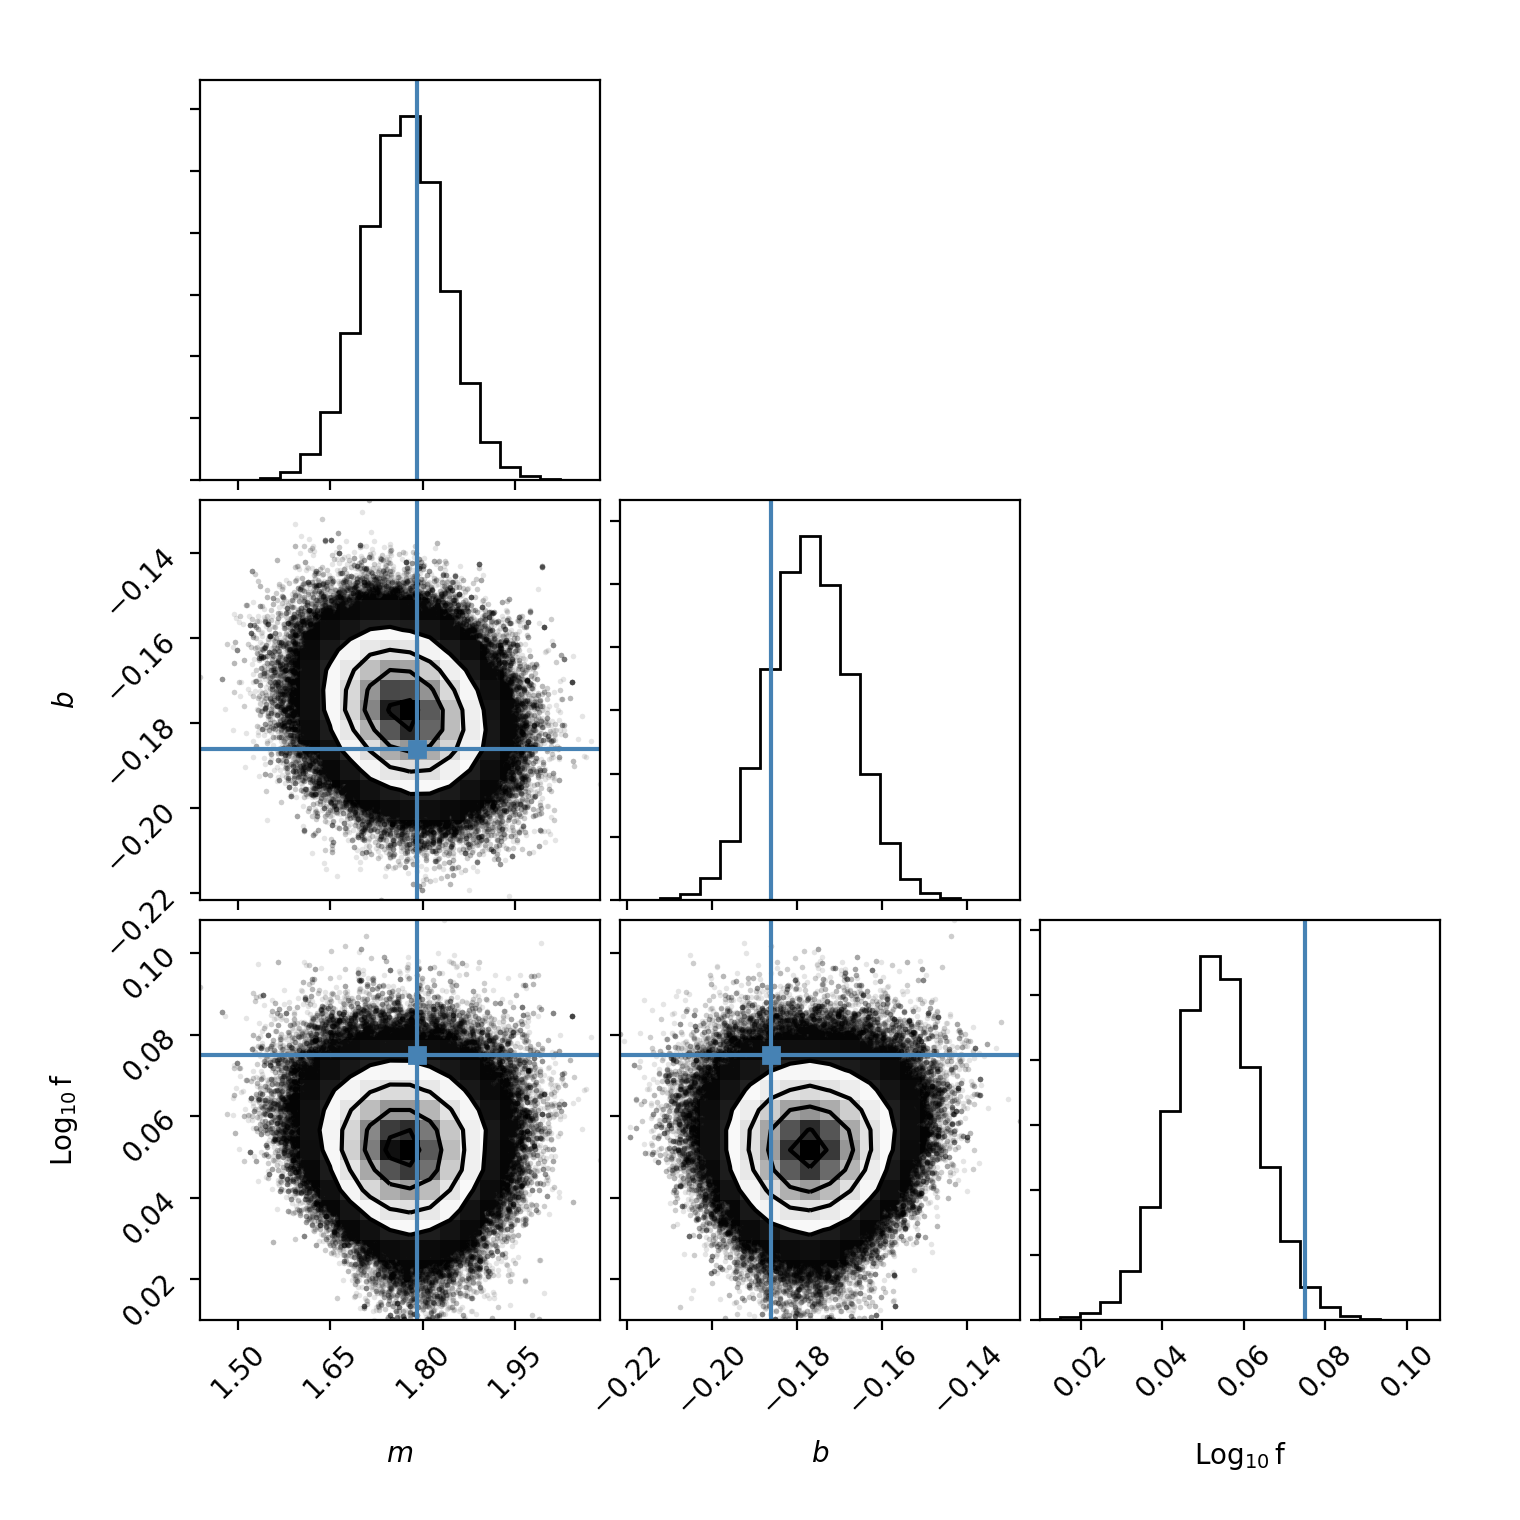

In [926]:
fig=corner.corner(samples, labels=["$m$", "$b$", r"$\rm{Log}_{10}\,f$"],truths=[m_true, b_true, (f_true)])

In [927]:
covmb=np.mean((samples[:,0]-np.mean(samples[:,0]))*(samples[:,1]-np.mean(samples[:,1])))
errm=np.std(samples[:,0]-np.mean(samples[:,0]))
errb=np.std(samples[:,1]-np.mean(samples[:,1]))
corr=covmb/(errm*errb)
print corr,covmb

-0.19974762921 -0.00012871864091


In [931]:
m,b,errm,errb,covmb=bces.bcesp(x,xerr,y,yerr,np.zeros_like(x),10000)
print m[3],errm[3],b[3],errb[3],covmb[3],covmb[3]/(errm[3]*errb[3])

BCES, 10000 trials... 
1.394691 s
1.855911317 0.0678132982268 -0.178337371639 0.00987616463252 -0.000162921393903 -0.243262367231


In [940]:
numdec=3
M500=linspace(2,24,1000)
norm=1e-4
figure()

errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["YSZ_500"]*norm,yerr=xsz_cat["YSZ_500_err"]*Ezgamma*norm,fmt="s",c="k",markersize=8,label=lbl)
plot(M500*1e14,(10.**b_mcmc[0])*((M500/6.)**m_mcmc[0])*norm,"k--")

<IPython.core.display.Javascript object>

NameError: name 'xsz_cat' is not defined

<IPython.core.display.Javascript object>


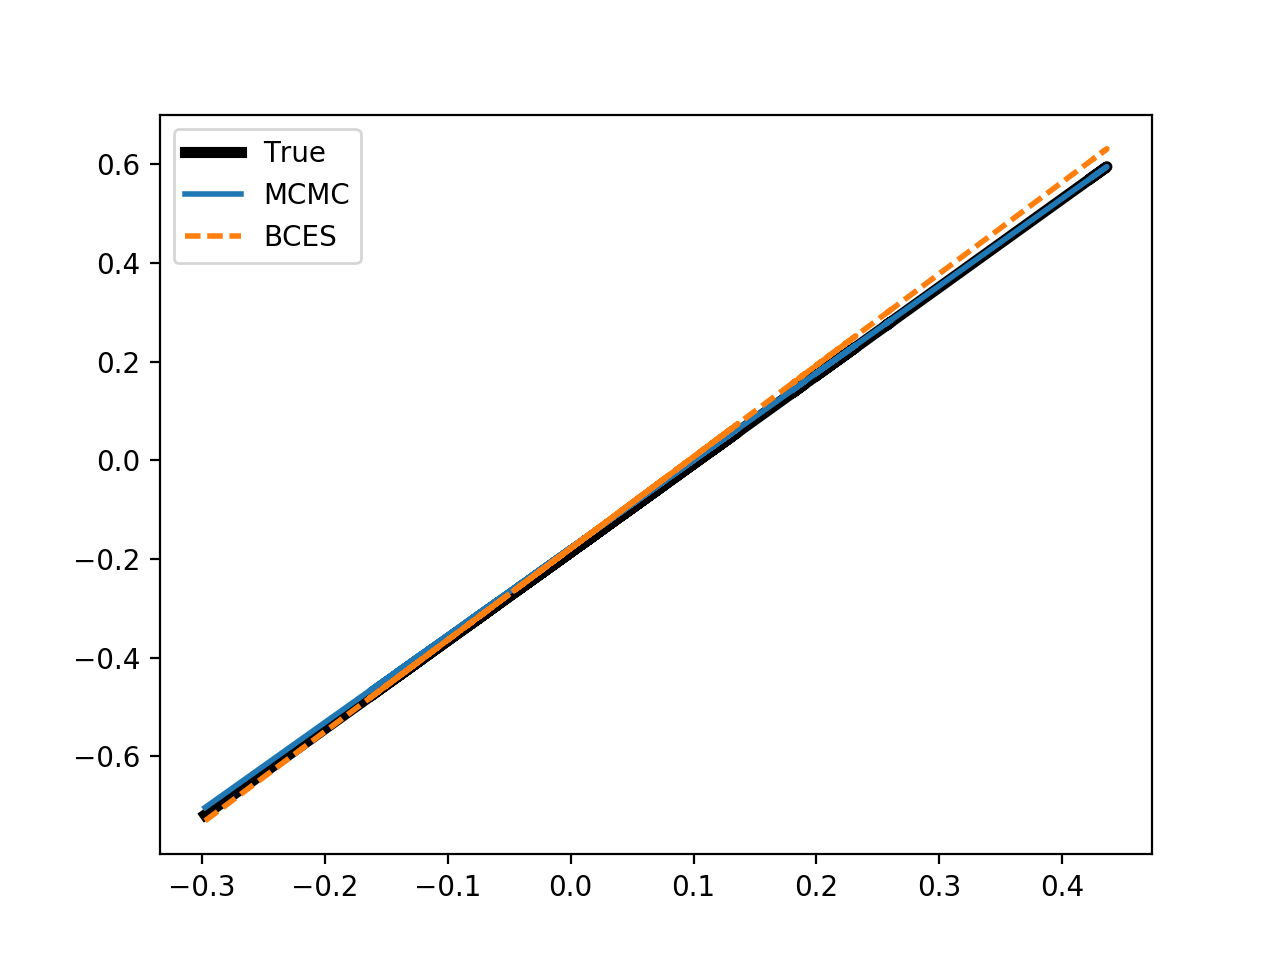

In [939]:
figure()
#errorbar(x,y,yerr=yerr,xerr=xerr,fmt="o")
plot(10.,exp(m_true*x+b_true,"k-",lw=4,label="True")
plot(exp(x),m_mcmc[0]*x+b_mcmc[0],lw=2,label="MCMC")
plot(exp(x),m[3]*x+b[3],"--",lw=2,label="BCES")
legend(loc=0)

